In [1]:
using Plots, Distributions, Random, StatsBase

# Simple SIR model

In [2]:
mutable struct Model_State
    I::Float64
    S::Float64
    R::Float64
end

function transition!(s::Model_State, χ::Float64, μ=1.0::FLoat64)
    # χ probability of being recovered
    # μ probability of catching the disease
    i_update = s.I * (1 - χ + μ * s.S)
    s_update = s.S * (1 - μ * s.I)
    r_update = s.R + χ * s.I
    s.I = i_update
    s.S = s_update
    s.R = r_update
    return
end    

function model_simulate!(s::Model_State, period::Int, χ::Float64, μ=1.0::FLoat64)
    for t in range(1,period)
        transition!(s,χ,μ)
    end
end

model_simulate! (generic function with 2 methods)

┌ Info: Saved animation to /var/folders/5f/1t5lz7t9659g_zvqs5c0tx180000gn/T/jl_0bAp0dOZiP.gif
└ @ Plots /Users/prld/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/5f/1t5lz7t9659g_zvqs5c0tx180000gn/T/jl_0bAp0dOZiP.gif")
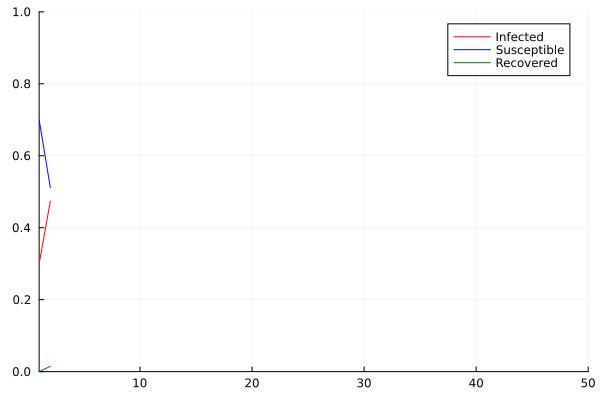

In [182]:
# Initialize state :
I0 = 0.3; S0=0.7; R0=0.0; χ=0.05; μ=0.9; n_iterr=50;
s = Model_State(I0, S0, R0)

# Initialize plot :
plt = plot([1],[s.I], xlim=(1,n_iterr), ylim=(0,1), c=:red, legend=:topright, label="Infected")
plot!([1],[s.S], c=:blue, label="Susceptible")
plot!([1],[s.R], c=:green, label="Recovered")

@gif for i in 2:n_iterr
    transition!(s,χ,μ)
    append!(plt,1,i,s.I)
    append!(plt,2,i,s.S)
    append!(plt,3,i,s.R)
end fps = 10

# A Spatial SIR model

In [175]:
# Number of agents
N = 100

#* CONSTANTS
χ=0.05; μ=0.9;
d = Normal(0,0.1)

mutable struct Agent
    x::Float64
    y::Float64
    h::String
end

# Initialize state :
# I0 = 0.3; S0=1-I0; R0=0.0;
#systeme = [Agent(rand(),rand(),"I") for i in range(1,round(I0*N))]
#append!(systeme,[Agent(rand(),rand(),"S") for i in range(1,N-round(I0*N))])

  0.014483 seconds (183.20 k allocations: 3.950 MiB, 82.83% compilation time)


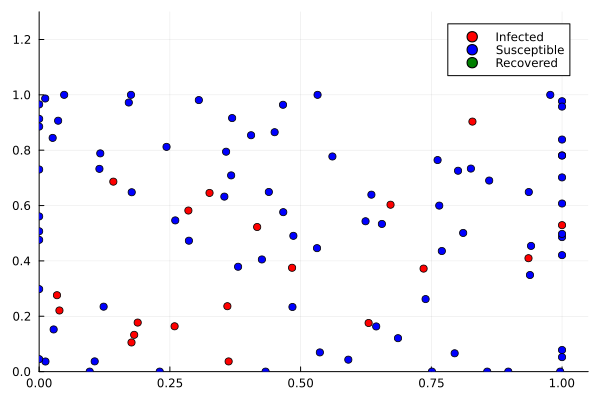

In [176]:
# -
#* Movement of agents
function spatial_transition!(S::Vector{Agent})
    for agt in S
        agt.x = min(max(agt.x + rand(d),0),1)
        agt.y = min(max(agt.y + rand(d),0),1)
    end
end

function random_guess(k::Int=Int(round(0.3*N)),T::Int=100)
    """
    - k : initial number of infected individuals / if no value set as 30% of population
    - T : number of shuffle
    """

    # Define and Initialize system
    if k>N
        print("Error number of initially infected larger than population")
        return nothing
    else
        S = [Agent(rand(),rand(),"I") for i in range(1,k)]
        append!(S,[Agent(rand(),rand(),"S") for i in range(1,N-k)])
    end

    for i in range(1,T)
        spatial_transition!(S)
    end
    return S
end
@time[random_guess()]

#* ------
function show_population(S::Vector{Agent})
    
    color = Dict("I"=>:red, "S"=>:blue, "R"=>:green)
    label = Dict("I"=>"Infected", "S"=>"Susceptible", "R"=>"Recovered")
    fig = plot(xlim=(0,1.05), ylim=(0,1.3), legend=:topright)

    for id in ["I","S","R"]
        sub = [x for x in S if x.h == id]
        scatter!(fig, [(agent.x,agent.y) for agent in sub], mc=color[id],label=label[id])
    end
    return fig
end

show_population(random_guess(20))

In [177]:
# Pour les probas : soit sampler depuis Uniforme(0,1) et regarder si <= χ (ou μ)
# Ou définir une nouvelle distribution et sampler depuis : sample([...],Weights([χ, 1-χ])) / pareil avec μ

#* EVOLUTION OF DISEASE INSIDE SYSTEM
function evolve!(S::Vector{Agent}, χ::Float64, μ::Float64)
    r = 0.05
    p_recover = Weights([χ, 1-χ])
    p_infect = Weights([μ, 1-μ])

    infected = [x for x in S if x.h == "I"]
    potential = [x for x in S if x.h == "S"]

    for infect in infected
        # Infecté proba χ to Recover
        infect.h = sample(["R","I"],p_recover)

        for pot in potential
            if sqrt((infect.x-pot.x)^2+(infect.y-pot.y)^2) <= r
                # Agent S proche d'un Infecté a proba μ de devenir infecté
                if sample(["I","S"],p_infect)=="I"
                    # S a été infecté = on l'enlève des pour autres I !! Gagne du temps de comparaison
                    filter!(x->x!=pot,potential)    
                    # Changement de statut en Infecté pour cet agent
                    pot.h = "I"
                end
            end
        end
    end
end 

function plot_evolve(S::Vector{Agent}, χ::Float64, μ::Float64)
    display(show_population(S))
    evolve!(S, χ, μ)
    display(show_population(S))
end

plot_evolve (generic function with 1 method)

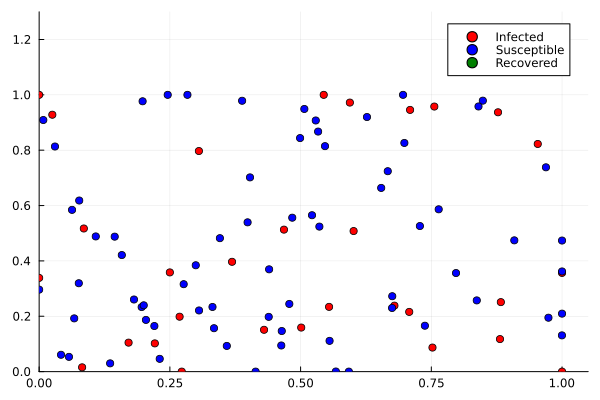

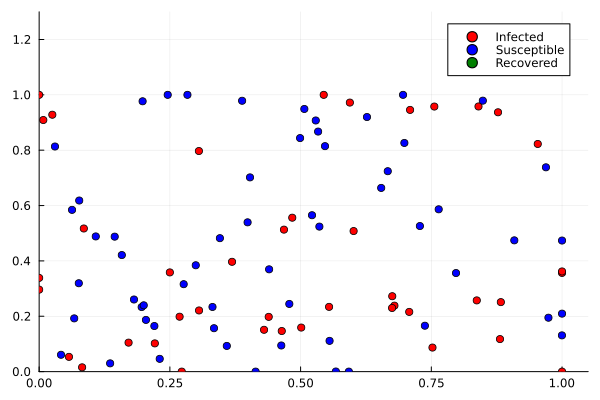

In [178]:
rt = random_guess()
plot_evolve(rt,χ,μ)

┌ Info: Saved animation to /var/folders/5f/1t5lz7t9659g_zvqs5c0tx180000gn/T/jl_MrQVMzyvUl.gif
└ @ Plots /Users/prld/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/var/folders/5f/1t5lz7t9659g_zvqs5c0tx180000gn/T/jl_MrQVMzyvUl.gif")
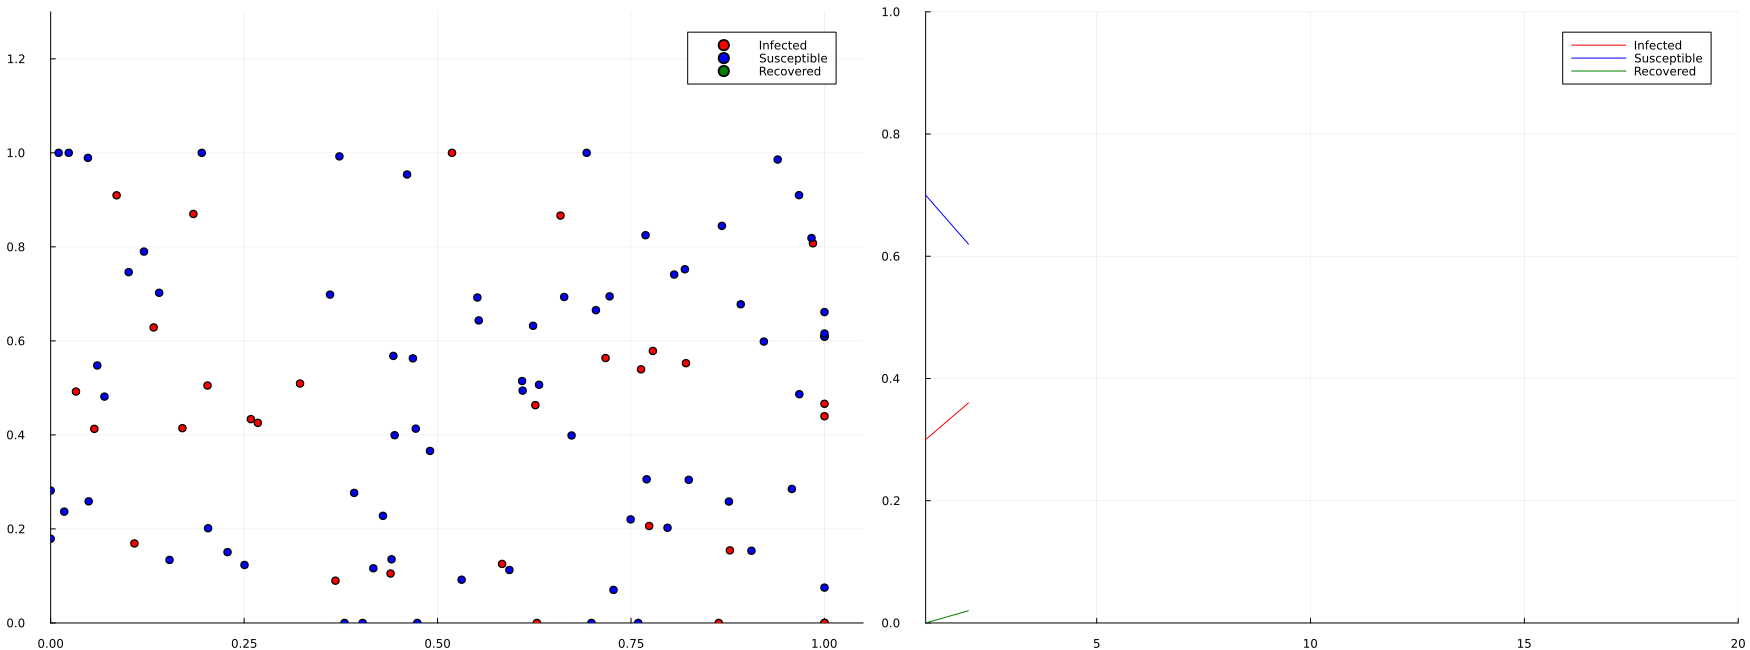

In [186]:
S0 = random_guess()
n_iterr = 20

color = Dict("I"=>:red, "S"=>:blue, "R"=>:green)
label = Dict("I"=>"Infected", "S"=>"Susceptible", "R"=>"Recovered")

#* SCATTER PLOT
fig_scat = plot(xlim=(0,1.05), ylim=(0,1.3), legend=:topright)

#* LINE PLOT
fig_line = plot([1],[ length([x for x in S0 if x.h == "I"])/N ], xlim=(1,n_iterr), ylim=(0,1), c=:red, legend=:topright, label="Infected")
plot!([1],[ length([x for x in S0 if x.h == "S"])/N ], c=:blue, label="Susceptible")
plot!([1],[ length([x for x in S0 if x.h == "R"])/N ], c=:green, label="Recovered")

#* ===========
anim = Animation()
for i in range(2,n_iterr)
    # (reset le plot)
    fig_scat = plot(xlim=(0,1.05), ylim=(0,1.3), legend=:topright)
    for id in ["I","S","R"]
        sub = [x for x in S0 if x.h == id]
        scatter!(fig_scat, [(agent.x,agent.y) for agent in sub], mc=color[id],label=label[id])
    end
    # --
    #TODO Combine evolve = update health status & spatial_transition = movement of agents
    evolve!(S0,χ,μ)
    spatial_transition!(S0)
    # --
    append!(fig_line,1,i, length([x for x in S0 if x.h == "I"])/N )
    append!(fig_line,2,i, length([x for x in S0 if x.h == "S"])/N )
    append!(fig_line,3,i, length([x for x in S0 if x.h == "R"])/N )
    # --
    plt = plot(fig_scat,fig_line, layout=2)
    plot(plt,size=(1750,650))
    frame(anim)
end
#* ===========
gif(anim, fps = 2)